### XGBoost with ADSTuner for HPO

* Imblearn for undersampling of negative class
* ADSTuner for HPO
* tuning on more parameters
* optimize using recall

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb

import ads

# to use ADSTuner
from ads.hpo.search_cv import ADSTuner
from ads.hpo.stopping_criterion import *
from ads.hpo.distributions import *

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# for undersampling the negative class
from imblearn.under_sampling import RandomUnderSampler

import matplotlib.pyplot as plt

import pickle

%matplotlib inline

In [2]:
# check the ADS version
print(ads.__version__)

2.5.4


In [9]:
# global constants
SEED = 4321

# number of features (without (16/03) the two indicator cols)
N_FEATURES = 12 - 2

# name of col with label
TARGET = 'SeriousDlqin2yrs'

# cols with missing values
COL1_MISSING = 'MonthlyIncome'
COL2_MISSING = 'NumberOfDependents'

# nomi delle due colonne indicator (valgono 1 laddove il dato è inputato)
IND1 = 'isna_mi'
IND2 = 'isna_nod'

ind_col = [IND1, IND2]

# 16/03 added indicators
COLS_TO_DROP = ['id', 'isna_mi', 'isna_nod']

# for undersampling to make the dataset more balanced
# ratio minority samples/majority
# with this ratio I get all the positive samples
RATIO = 1./5.

In [10]:
# full dataset, not undersampled
data_full = pd.read_csv('cs-training-nonull.csv')

# remove unneeded cols
data_full = data_full.drop(COLS_TO_DROP, axis = 1)

In [11]:
cat_cols = ['age','NumberOfTime30-59DaysPastDueNotWorse',
               'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
               'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
               'NumberOfDependents']
num_cols = ['RevolvingUtilizationOfUnsecuredLines', 'DebtRatio', 'MonthlyIncome', ]

# indicators are not touched

In [12]:
# scaling and label encoding is done on data_full. After we will do resampling
# In this way coding and scaling cover entire range of values, not only for resampled data

# we don't need any scaling (it is ensambles of trees)

In [13]:
# cat cols treatment
# Code categorical columns (only season, weather, year)

# we don't need any pre-processing for cat columns

# so for XGBoost afpret Nan treatment no other pre-processing is needed

In [14]:
# estrae X: matrice features ed y, labels
y_train_full = data_full[TARGET].values
x_train_full = data_full.drop(TARGET, axis = 1).values

assert x_train_full.shape[1] == N_FEATURES

In [15]:
print(f'# of samples in full dataset: {x_train_full.shape[0]}')
print(f'# of positive samples: {np.sum(y_train_full)}')
print(f'# of negative samples: {x_train_full.shape[0] - np.sum(y_train_full)}')

# of samples in full dataset: 150000
# of positive samples: 10026
# of negative samples: 139974


In [16]:
# do the undersampling of the negative class, using IMblearn
rus = RandomUnderSampler(sampling_strategy=RATIO, random_state=SEED)

x_train, y_train = rus.fit_resample(x_train_full, y_train_full)

print(f'# of samples in resampled dataset: {x_train.shape[0]}')

# check ratio of classes
print(f'# of positive samples: {np.sum(y_train)}')
print(f'# of negative samples: {x_train.shape[0] - np.sum(y_train)}')

# of samples in resampled dataset: 60156
# of positive samples: 10026
# of negative samples: 50130


The resampled dataset (x_train, y_train) will be used for training

### Train the XGBoost Classifier

In [17]:
# parameters for the HPO session with Optuna
FOLDS = 5
SEED = 4321

N_TRIALS = 100
TIME_BUDGET = 7200
STUDY_NAME = "xgb01"

# ranges
LR_LOW = 1e-3
LR_HIGH = 1e-2
DEPTH_LOW = 4
DEPTH_HIGH = 10
N_ITER_LIST = [1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500]
GAMMA_LOW = 0.1
GAMMA_HIGH = 5
SUBSAMPLE_LOW = 0.1
SUBSAMPLE_HIGH = 1.

In [18]:
#
# Here we define the strategy, the space for hyper-parameters we want to explore
#
params = {
    "n_estimators": CategoricalDistribution(N_ITER_LIST),
    "learning_rate": LogUniformDistribution(low=LR_LOW, high=LR_HIGH),
    "max_depth": IntUniformDistribution(DEPTH_LOW, DEPTH_HIGH),
    "gamma" : LogUniformDistribution(low=GAMMA_LOW, high=GAMMA_HIGH),
    "subsample" : UniformDistribution(low=SUBSAMPLE_LOW, high=SUBSAMPLE_HIGH),
    "tree_method": "gpu_hist"
}

clf = xgb.XGBClassifier()


# per lista scorer sorted(sklearn.metrics.SCORERS.keys())
tuner = ADSTuner(clf, cv=FOLDS, strategy=params, scoring="recall", study_name=STUDY_NAME, n_jobs=10, random_state=SEED)

tuner.tune(x_train, y_train, exit_criterion=[TimeBudget(TIME_BUDGET)])

[I 2022-03-16 09:48:25,322] A new study created in RDB with name: xgb01


In [75]:
# get the status to see if completed
print(f"The tuner status is: {tuner.get_status()}")

print(f"Remaining time is: {round(tuner.time_remaining, 1)} sec.")

The tuner status is: State.COMPLETED
Remaining time is: 0 sec.


In [76]:
# look only at completed trials, sorted with best on top. Metric chosen is in the value col.
result_df = tuner.trials[tuner.trials["state"] == "COMPLETE"].sort_values(
    by=["value"], ascending=False
)

result_df.head(10)

,number,value,datetime_start,datetime_complete,duration,params_gamma,params_learning_rate,params_max_depth,params_n_estimators,params_subsample,...,user_attrs_metric,user_attrs_split0_test_score,user_attrs_split1_test_score,user_attrs_split2_test_score,user_attrs_split3_test_score,user_attrs_split4_test_score,user_attrs_std_fit_time,user_attrs_std_score_time,user_attrs_std_test_score,state
30,30,0.442350,2022-03-16 10:13:55.556934,2022-03-16 10:22:56.917131,0 days 00:09:01.360197,0.362415,0.009758,8,1900,0.103116,...,recall,0.440678,0.447382,0.428429,0.447880,0.447382,1.223023,0.003069,0.007454,COMPLETE
31,31,0.441652,2022-03-16 10:14:50.201208,2022-03-16 10:24:39.580061,0 days 00:09:49.378853,0.266504,0.009470,8,1900,0.130487,...,recall,0.438684,0.443890,0.432918,0.441397,0.451372,3.310752,0.002672,0.006077,COMPLETE
72,72,0.441353,2022-03-16 11:13:33.400944,2022-03-16 11:18:07.284934,0 days 00:04:33.883990,0.298590,0.009068,6,2000,0.100879,...,recall,0.439681,0.443392,0.427930,0.447382,0.448379,0.660419,0.000857,0.007387,COMPLETE
28,28,0.441253,2022-03-16 10:10:54.426753,2022-03-16 10:20:05.301596,0 days 00:09:10.874843,0.346848,0.009590,8,1900,0.112343,...,recall,0.440179,0.443392,0.423441,0.445387,0.453865,0.982412,0.011925,0.009991,COMPLETE
71,71,0.440854,2022-03-16 11:13:08.592541,2022-03-16 11:20:20.122942,0 days 00:07:11.530401,0.280380,0.007254,7,1900,0.146281,...,recall,0.434197,0.441397,0.427431,0.443392,0.457855,0.949991,0.001493,0.010201,COMPLETE
81,81,0.440854,2022-03-16 11:18:46.058020,2022-03-16 11:25:45.076694,0 days 00:06:59.018674,0.398462,0.007508,7,2000,0.100816,...,recall,0.439182,0.443392,0.426434,0.444389,0.450873,0.659269,0.002766,0.008125,COMPLETE
4,4,0.440654,2022-03-16 09:48:25.954038,2022-03-16 09:53:22.831772,0 days 00:04:56.877734,3.754146,0.006738,10,1900,0.430254,...,recall,0.440678,0.437905,0.422444,0.449377,0.452868,1.981264,0.004072,0.010625,COMPLETE
66,66,0.440456,2022-03-16 11:09:47.010077,2022-03-16 11:16:54.300950,0 days 00:07:07.290873,0.273102,0.008763,7,1900,0.147134,...,recall,0.429711,0.445387,0.431920,0.444888,0.450374,1.509002,0.002822,0.008132,COMPLETE
82,82,0.440455,2022-03-16 11:19:58.558181,2022-03-16 11:23:34.418455,0 days 00:03:35.860274,0.660394,0.007380,6,1600,0.101541,...,recall,0.435693,0.440898,0.428429,0.446384,0.450873,0.387309,0.004003,0.007889,COMPLETE
22,22,0.440256,2022-03-16 10:01:56.586277,2022-03-16 10:17:05.507551,0 days 00:15:08.921274,0.257564,0.009619,10,1900,0.101360,...,recall,0.431705,0.440399,0.433416,0.443890,0.451870,0.964781,0.006283,0.007321,COMPLETE


In [77]:
def show_tuner_results(tuner):

    # to count completed
    result_df = tuner.trials[tuner.trials["state"] == "COMPLETE"].sort_values(
        by=["value"], ascending=False
    )

    print("ADSTuner session results:")
    print(f"ADSTuner has launched {tuner.trials.shape[0]} trials")
    print(f"ADSTuner has completed {result_df.shape[0]} trials")
    print()
    print(f"The best trial is the #: {tuner.best_index}")
    print(f"Parameters for the best trial are: {tuner.best_params}")
    print(f"The metric used to optimize is: {tuner.scoring_name}")
    print(f"The best score is: {round(tuner.best_score, 4)}")
    
show_tuner_results(tuner)

ADSTuner session results:
ADSTuner has launched 112 trials
ADSTuner has completed 112 trials

The best trial is the #: 30
Parameters for the best trial are: {'gamma': 0.3624145784289698, 'learning_rate': 0.009757611547413204, 'max_depth': 8, 'n_estimators': 1900, 'subsample': 0.10311561378997164, 'tree_method': 'gpu_hist'}
The metric used to optimize is: recall
The best score is: 0.4424


### Train with best params

In [79]:
%%time

clf = xgb.XGBClassifier(**tuner.best_params)

# addestro e valuto su train e su validation set
clf.fit(x_train, y_train,
        eval_set=[(x_train, y_train)],
        eval_metric='auc', verbose=100)

print()

evals_result = clf.evals_result()

[0]	validation_0-auc:0.83656
[100]	validation_0-auc:0.87152
[200]	validation_0-auc:0.87561
[300]	validation_0-auc:0.87927
[400]	validation_0-auc:0.88237
[500]	validation_0-auc:0.88530
[600]	validation_0-auc:0.88786
[700]	validation_0-auc:0.89052
[800]	validation_0-auc:0.89296
[900]	validation_0-auc:0.89521
[1000]	validation_0-auc:0.89768
[1100]	validation_0-auc:0.89974
[1200]	validation_0-auc:0.90167
[1300]	validation_0-auc:0.90372
[1400]	validation_0-auc:0.90564
[1500]	validation_0-auc:0.90747
[1600]	validation_0-auc:0.90944
[1700]	validation_0-auc:0.91111
[1800]	validation_0-auc:0.91270
[1899]	validation_0-auc:0.91430

CPU times: user 10.5 s, sys: 968 ms, total: 11.5 s
Wall time: 11.4 s


#### OK, consider that the slightly higher AUC is due to the fact here we're evaluating also on train data

In [ ]:
def plot_auc(train_hist):
    plt.figure(figsize=(9,6))
    
    plt.plot(train_hist, label='Training AUC')
    plt.title('AUC')
    plt.legend(loc='lower right')
    plt.ylabel('auc')
    plt.xlabel('n_estimator')
    plt.grid(True)
    plt.show();

In [ ]:
train_hist = evals_result['validation_0']['auc']

plot_auc(train_hist)

In [80]:
# compute accuracy on full dataset
y_pred = clf.predict(x_train_full)

# not really needed for XGBoost
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_train_full, predictions)

print("Accuracy on train set: %.2f%%" % (accuracy * 100.0))

Accuracy on train set: 93.20%


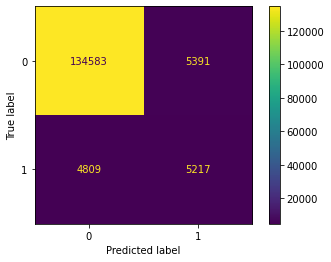

In [81]:
# compute confusion matrix on full dataset
cm = confusion_matrix(y_train_full, predictions)

# plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot();

In [83]:
# the number of FN is rather high but using recall things get better

### Prediction on the TEST set (for submission to Kaggle)

In [95]:
# predictions on test set
orig_test = pd.read_csv('cs-test.csv')

In [96]:
# inpute missing values, add the two indicator columns
MONTHLY_INC_MEDIAN = 5400.
N_OF_DEP_MODE = 0

orig_test['isna_mi'] = 0
orig_test.loc[orig_test[COL1_MISSING].isna(), 'isna_mi'] = 1
orig_test.loc[orig_test[COL1_MISSING].isna(), COL1_MISSING] = MONTHLY_INC_MEDIAN

orig_test['isna_nod'] = 0
orig_test.loc[orig_test[COL2_MISSING].isna(), 'isna_nod'] = 1
orig_test.loc[orig_test[COL2_MISSING].isna(), COL2_MISSING] = N_OF_DEP_MODE

In [97]:
ind_test = orig_test[ind_col].values

In [98]:
orig_test = orig_test.drop(ind_col, axis = 1)

In [99]:
orig_test.columns

Index(['Unnamed: 0', 'SeriousDlqin2yrs',
       'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')

In [100]:
ID_COL_NAME = 'Unnamed: 0'
xorig_test = orig_test.drop(ID_COL_NAME, axis = 1)
xorig_test = xorig_test.drop(TARGET, axis = 1)

x_test = xorig_test.values

In [ ]:
# aggiungi qui lo scaling !!!
x_test_scaled = scaler.transform(x_test)
# riaggiunge le colonne indicatore
x_test_scaled = np.c_[x_test_scaled, ind_test]

assert x_test_scaled.shape[1] == N_FEATURES

In [101]:
# do predictions on test set (no shuffle !)
y_pred = clf.predict_proba(x_test)

# y_pred contiene le probabilità
y_pred = y_pred[:, 1]

In [102]:
# prepara il csv per la submission
result_dict = {"Id": orig_test[ID_COL_NAME].values,
              'Probability': y_pred}

FILE_SUB = 'submission36.csv'

# build a dataframe and save to csv
result_df = pd.DataFrame(result_dict)

result_df.to_csv(FILE_SUB, index=False, float_format='%.5f')

In [ ]:
### Save Modela and scaler

In [ ]:
# save model: uso un formato semplice: pkl
pickle.dump(clf, open("credit-scoring.pkl", "wb"))

In [ ]:
# salvo anche lo scaler
pickle.dump(scaler, open("scaler.pkl", "wb"))

### Online predictions

In [ ]:
# reload the model
loaded_model = pickle.load(open("credit-scoring.pkl", "rb"))

In [ ]:
# reload the scaler
loaded_scaler = pickle.load(open("scaler.pkl", "rb"))

In [ ]:
# prepare for online predictions
# input are given as a numpy array, with no missing fields, but we need to add the two indicator columns
x_input = np.array([[1,2,3,4,5,6,7,8,9,10],
                   [1,2,3,4,5,6,7,8,9,10],
                   [1,2,3,4,5,6,7,8,9,10]])

In [ ]:
# controlli
assert x_input.shape[1] == 10
# check there are no null
assert np.sum(np.isnan(x_input)) == 0

In [ ]:
# normalize
x_input_scaled = loaded_scaler.transform(x_input)

# add two columns with 0
x_add = np.zeros((x_input.shape[0], 2))
x_input_scaled = np.c_[x_input_scaled, x_add]

In [ ]:
y_pred = loaded_model.predict(x_input_scaled)

In [ ]:
y_pred

In [ ]:
train_df[TARGET].hist();